In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import seaborn as sns

In [2]:
from project_fraud.lib import drop_many_missing_values

In [3]:
data = drop_many_missing_values()

In [4]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}


##us_emails = ['gmail',  'net',  'edu']

# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499#latest-579654
for c in ['P_emaildomain']:
    data[c + '_bin'] = data[c].map(emails)
    data[c + '_suffix'] = data[c].map(lambda x: str(x).split('.')[-1])
    



In [5]:
def make_day_feature(data, offset=0, column_name='TransactionDT'):

    days = data[column_name] / (3600*24)        
    encoded_days = np.floor(days-1+offset) % 7
    return encoded_days

In [6]:
def make_hour_feature(data, column_name='TransactionDT'):

    hours = data[column_name] / (3600)        
    encoded_hours = np.floor(hours) % 24
    return encoded_hours

(0.0, 1000.0)

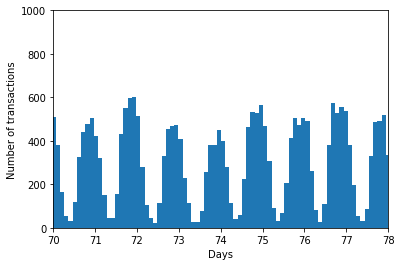

In [7]:
vals = plt.hist(data['TransactionDT'] / (3600*24), bins=1800)
plt.xlim(70, 78)
plt.xlabel('Days')
plt.ylabel('Number of transactions')
plt.ylim(0,1000)

Text(0, 0.5, 'Fraction of fraudulent transactions')

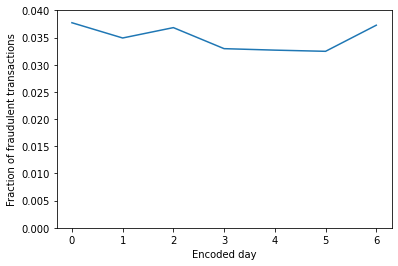

In [8]:
# create new feature weekday
# offset to define start of the day: 0.85

data['weekday'] = make_day_feature(data, offset=0.58)

plt.plot(data.groupby('weekday').mean()['isFraud'])

plt.ylim(0, 0.04)
plt.xlabel('Encoded day')
plt.ylabel('Fraction of fraudulent transactions')

Text(0, 0.5, 'Number of transactions')

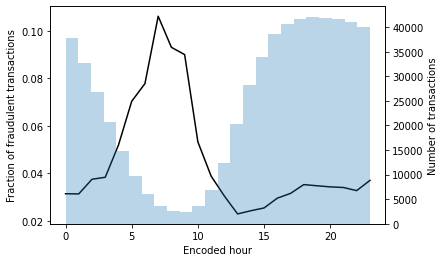

In [9]:
# create a feature which encodes the (relative) hour of the day

data['hours'] = make_hour_feature(data)

plt.plot(data.groupby('hours').mean()['isFraud'], color='k')


ax = plt.gca()
ax2 = ax.twinx()
_ = ax2.hist(data['hours'], alpha=0.3, bins=24)
ax.set_xlabel('Encoded hour')
ax.set_ylabel('Fraction of fraudulent transactions')

ax2.set_ylabel('Number of transactions')

In [10]:
def function(row):
    if pd.isna(row['card1']):
        return np.nan
    elif pd.isna(row['card2']):
        return np.nan
    elif pd.isna(row['card3']):
        return np.nan
    elif pd.isna(row['card4']):
        return np.nan
    elif pd.isna(row['card5']):
        return np.nan
    elif pd.isna(row['card6']):
        return np.nan
    else: 
        return str(row['card1']) + str(row['card2']) + str(row['card3']) + str(row['card4']) + str(row['card5']) + str(row['card6'])

In [11]:
data['cardID'] = data.apply(lambda row: function(row), axis=1)



In [15]:
credit_cards = data.groupby('cardID').agg(
    mean = pd.NamedAgg(column='TransactionAmt', aggfunc='mean'), 
    min = pd.NamedAgg(column='TransactionAmt', aggfunc='min'), 
    max = pd.NamedAgg(column='TransactionAmt', aggfunc='max'),
    median = pd.NamedAgg(column='TransactionAmt', aggfunc='median'),
)

In [16]:
data = data.merge(credit_cards, how='left', on="cardID")

In [17]:
def dist_from_mean(row, metric): 
    if pd.isna(row['TransactionAmt']):
        return np.nan
    if pd.isna(row[metric]):
        return np.nan
    else: 
        dist = row['TransactionAmt'] - row[metric]
        return dist

In [18]:
data['dist_mean'] = data.apply(lambda row: dist_from_mean(row, 'mean'), axis=1)
data['dist_median'] = data.apply(lambda row: dist_from_mean(row, 'median'), axis=1)

In [19]:
def dist_from_median_rel(row, metric): 
    if pd.isna(row['TransactionAmt']):
        return np.nan
    if pd.isna(row[metric]):
        return np.nan
    else: 
        dist_rel = (row['TransactionAmt'] - row[metric]) / row[metric]
        return dist_rel

In [20]:
data['dist_mean_rel'] = data.apply(lambda row: dist_from_median_rel(row, 'mean'), axis=1)

In [21]:
data['dist_median_rel'] = data.apply(lambda row: dist_from_median_rel(row, 'median'), axis=1)

# imports 

In [22]:
#import tensorflow as tf

from sklearn.pipeline import make_pipeline
#from tensorflow.keras import metrics
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from scipy import stats


#visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from pylab import rcParams
#from tensorflow.keras.models import Model, load_model
#from tensorflow.keras.layers import Input, Dense
#from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
#from tensorflow.keras import regularizers



#models 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


# Imputing missing values 

In [23]:
X = data[['TransactionID',
'card1','card2','addr1','TransactionAmt','card5','D15','C13','D2','D10','D4','weekday','hours',\
           'dist_mean', 'dist_median','dist_mean_rel','dist_median_rel']]
y = data['isFraud']

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)

In [25]:
sample_size = 15000
X_small = X_train.sample(sample_size, random_state=0)
y_small = y_train.sample(sample_size, random_state=0)

In [26]:
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small, y_small, random_state=0)

In [27]:
n = (X.dtypes != 'object')
num_cols = list(n[n].index)
medium_missing_num_cols = []
low_missing_num_cols =[]
for i in num_cols:
    percentage = data[i].isnull().sum() * 100 / len(data[i])
    if percentage < 15:
        low_missing_num_cols.append(i)
    elif percentage >= 15 and percentage <= 60:
        medium_missing_num_cols.append(i)

In [30]:
num_transformer_low = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])
num_transformer_medium = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant')),
    ('one_hot', OneHotEncoder())
])
    
preprocessor = ColumnTransformer([
    ('low_num_imputer',num_transformer_low, low_missing_num_cols),
    ('medium_num_imputer', num_transformer_medium, medium_missing_num_cols),
    ('cat_transformer', cat_pipeline, ['weekday','hours'])],
    remainder='drop')





# MODELS 
## - LogisticRegression()
## - RandomForestClassifier()
## - KNeighborsClassifier()
## - SVC()


# 1.  LOGISTIC REGRESSION

In [40]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])


    # Tune model hyperparameters
param_grid = {'classifier__class_weight': ['balanced', None],
              "classifier__penalty": ['l2','l1'],
              "classifier__C": np.logspace(0, 4, 10)}
grid_search = GridSearchCV(clf, param_grid,
                           cv=5,
                           n_jobs=2,
                           verbose=0,
                           scoring= 'recall')

grid_search.fit(X_train_small, y_train_small)



#clf.fit(X_train, y_train)

/Users/mariarumyantseva/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('low_num_imputer',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['TransactionID',
                                                                          'card1',
                                                                          'card2',
                                                                          'addr1',
                                                                         

In [41]:
grid_search.score(X_test_small, y_test_small)

0.632

# 2. RANDOM FOREST

 For example, common wisdom suggests that training a large number of trees and growing deep trees whose leaf sizes are fixed to a small constant lead to better per- formance. 

In [ ]:
#ginni

clf = RandomForestClassifier()
model = Pipeline([('preprocessor', preprocessor),
                      ('classifier', clf)])

param_grid = {'classifier__class_weight': ['balanced', None],
             'classifier__n_estimators' : [50,100,200],
             'classifier__max_depth' :[5,8,15,25,30,None],
              'classifier__min_samples_leaf':[1,2,5,10,15,100],
              'classifier__max_leaf_nodes': [2, 5,10]}
grid_search = GridSearchCV(model , param_grid,
                           cv=5,
                           n_jobs=2,
                           verbose=0,
                           scoring= 'recall')

grid_search.fit(X_train_small, y_train_small)




In [ ]:
grid_search.score(X_test_small, y_test_small)

# 3. KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=15)
scale = StandardScaler()
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", knn)
    
])


param_grid = {'classifier__weights': ['uniform'],
              'classifier__n_neighbors' : [1,5,10,15]
             }

grid_search = GridSearchCV(pipeline, param_grid,
                           cv=5,
                           n_jobs=2,
                           verbose=0,
                           scoring= 'recall')

grid_search.fit(X_train_small, y_train_small)




In [ ]:
grid_search.score(X_test_small, y_test_small)

# 4. SVC

In [31]:
from scipy import stats 
from sklearn.model_selection import RandomizedSearchCV

# Instanciate model
svc = SVC()


pipeline_svc = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", svc),
     ])

param_grid = {'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'classifier__gamma' : stats.uniform(0.001 , 10),
              'classifier__C': stats.uniform(0.001,10), 
              'classifier__class_weight': ['balanced']
             }
#param_grid  = {
    
    #'C': stats.uniform(0.01, 1000),
    #'gamma': stats.loguniform(0.001,10),
    #'coef0': stats.uniform(-5,5),
        #}




random_search = RandomizedSearchCV(pipeline_svc, param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2,
                           n_iter=30,        
                           scoring= 'recall')




random_search.fit(X_train_small, y_train_small)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  8.6min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('low_num_imputer',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['TransactionID',
                                                                                'card1',
                                                                                'card2',
                                                                                'addr1',
       

In [34]:
from scipy import stats 
from sklearn.model_selection import RandomizedSearchCV

# Instanciate model
svc = SVC()


pipeline_svc = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", svc),
     ])

param_grid_2 = {'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'classifier__gamma' : stats.uniform(0.001 , 10),
              'classifier__C': stats.uniform(0.001,10), 
              'classifier__class_weight': ['balanced']
             }
#param_grid  = {
    
    #'C': stats.uniform(0.01, 1000),
    #'gamma': stats.loguniform(0.001,10),
    #'coef0': stats.uniform(-5,5),
        #}




random_search_2 = RandomizedSearchCV(pipeline_svc, param_grid_2,
                           cv=5,
                           n_jobs=-1,
                           verbose=2,
                           n_iter=30,        
                           scoring= 'f1')




random_search_2.fit(X_train_small, y_train_small)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  7.0min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('low_num_imputer',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['TransactionID',
                                                                                'card1',
                                                                                'card2',
                                                                                'addr1',
       

In [35]:
random_search_2.best_score_

0.09086619875340915

In [32]:
random_search.best_score_

0.7337657657657657

In [33]:
random_search.best_params_

{'classifier__C': 0.039905018135327874,
 'classifier__class_weight': 'balanced',
 'classifier__gamma': 5.284807908082844,
 'classifier__kernel': 'linear'}

In [40]:
new_model = random_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('low_num_imputer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TransactionID', 'card1',
                                                   'card2', 'addr1',
                                                   'TransactionAmt', 'card5',
                                                   'C13', 'D10', 'weekday',
                                                   'hours', 'dist_mean',
                                                   'dist_median',
                                                   'dist_mean_rel',
                                                   'dist_median

# 5. AUTOENCODER

In [ ]:
preprocessor.fit(X_train)


X_train_prep = preprocessor.transform(X_train_small)

X_test_prep = preprocessor.transform(X_test_small)

In [ ]:
preprocessor.fit(X_train)

X_auto_prep = preprocessor.transform(X_auto_small)

In [ ]:
nb_epoch = 50
batch_size = 128
input_dim = X_train_prep.shape[1] #num of columns, 30
encoding_dim = 18
hidden_dim1 = 10 #int(encoding_dim / 2) #i.e. 7
hidden_dim2 = 6
learning_rate = 1e-7


In [ ]:
# This returns a tensor
input_layer = Input(shape=(input_dim, ))

# a layer instance is callable on a tensor, and returns a tensor
# Dense implements the operation: output = activation(dot(input, kernel) + bias), where
# activation is the element-wise activation function passed as the activation argument, 
# kernel is a weights matrix created by the layer, and 
# bias is a bias vector created by the layer (only applicable if use_bias is True).

# activity_regularizer: Regularizer function applied to the output of the layer
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim1, activation="elu")(encoder)
encoder = Dense(hidden_dim2, activation="tanh")(encoder)
decoder = Dense(hidden_dim2, activation='elu')(encoder)
decoder = Dense(hidden_dim1, activation='tanh')(decoder)
decoder = Dense(input_dim, activation='elu')(decoder)

# This creates a model that includes
# the Input layer and four Dense layers
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [ ]:
autoencoder.compile(optimizer='adam',
                    metrics=['accuracy'],
                    loss='mean_squared_error')

# History.history attribute is a record of training loss values 
# and metrics values at successive epochs.
history = autoencoder.fit(x= X_auto_prep , y=X_auto_prep ,
                          epochs=150,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_split=0.2,
                          verbose=1).history

In [ ]:


plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
test_x_predictions = autoencoder.predict(X_test_prep)
mse = np.mean(np.power((X_test_prep) - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test_small})
error_df.describe()

In [ ]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class,
                                                      error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)


In [ ]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class,
                                                               error_df.Reconstruction_error)

pr_auc = auc(recall_rt, precision_rt,)


In [ ]:
recall_rt[:].mean()

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [ ]:
threshold_fixed = 0.025
groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(14, 8))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1],
          colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import seaborn as sns

from project_fraud.lib import drop_many_missing_values

data = drop_many_missing_values()

emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}


##us_emails = ['gmail',  'net',  'edu']

# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499#latest-579654
for c in ['P_emaildomain']:
    data[c + '_bin'] = data[c].map(emails)
    data[c + '_suffix'] = data[c].map(lambda x: str(x).split('.')[-1])
    



def make_day_feature(data, offset=0, column_name='TransactionDT'):

    days = data[column_name] / (3600*24)        
    encoded_days = np.floor(days-1+offset) % 7
    return encoded_days

def make_hour_feature(data, column_name='TransactionDT'):

    hours = data[column_name] / (3600)        
    encoded_hours = np.floor(hours) % 24
    return encoded_hours

vals = plt.hist(data['TransactionDT'] / (3600*24), bins=1800)
plt.xlim(70, 78)
plt.xlabel('Days')
plt.ylabel('Number of transactions')
plt.ylim(0,1000)

# create new feature weekday
# offset to define start of the day: 0.85

data['weekday'] = make_day_feature(data, offset=0.58)

plt.plot(data.groupby('weekday').mean()['isFraud'])

plt.ylim(0, 0.04)
plt.xlabel('Encoded day')
plt.ylabel('Fraction of fraudulent transactions')

# create a feature which encodes the (relative) hour of the day

data['hours'] = make_hour_feature(data)

plt.plot(data.groupby('hours').mean()['isFraud'], color='k')


ax = plt.gca()
ax2 = ax.twinx()
_ = ax2.hist(data['hours'], alpha=0.3, bins=24)
ax.set_xlabel('Encoded hour')
ax.set_ylabel('Fraction of fraudulent transactions')

ax2.set_ylabel('Number of transactions')

def function(row):
    if pd.isna(row['card1']):
        return np.nan
    elif pd.isna(row['card2']):
        return np.nan
    elif pd.isna(row['card3']):
        return np.nan
    elif pd.isna(row['card4']):
        return np.nan
    elif pd.isna(row['card5']):
        return np.nan
    elif pd.isna(row['card6']):
        return np.nan
    else: 
        return str(row['card1']) + str(row['card2']) + str(row['card3']) + str(row['card4']) + str(row['card5']) + str(row['card6'])

data['cardID'] = data.apply(lambda row: function(row), axis=1)



credit_cards = data.groupby('cardID').agg(
    mean = pd.NamedAgg(column='TransactionAmt', aggfunc='mean'), 
    min = pd.NamedAgg(column='TransactionAmt', aggfunc='min'), 
    max = pd.NamedAgg(column='TransactionAmt', aggfunc='max'),
    median = pd.NamedAgg(column='TransactionAmt', aggfunc='median'),
)

data = data.merge(credit_cards, how='left', on="cardID")

def dist_from_mean(row, metric): 
    if pd.isna(row['TransactionAmt']):
        return np.nan
    if pd.isna(row[metric]):
        return np.nan
    else: 
        dist = row['TransactionAmt'] - row[metric]
        return dist

data['dist_mean'] = data.apply(lambda row: dist_from_mean(row, 'mean'), axis=1)
data['dist_median'] = data.apply(lambda row: dist_from_mean(row, 'median'), axis=1)

def dist_from_median_rel(row, metric): 
    if pd.isna(row['TransactionAmt']):
        return np.nan
    if pd.isna(row[metric]):
        return np.nan
    else: 
        dist_rel = (row['TransactionAmt'] - row[metric]) / row[metric]
        return dist_rel

data['dist_mean_rel'] = data.apply(lambda row: dist_from_median_rel(row, 'mean'), axis=1)

data['dist_median_rel'] = data.apply(lambda row: dist_from_median_rel(row, 'median'), axis=1)





# imports 

from sklearn.pipeline import make_pipeline
from tensorflow.keras import metrics
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from scipy import stats

import tensorflow as tf



#visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from pylab import rcParams
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers



#models 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


# Imputing missing values 

X = data[['TransactionID','P_emaildomain_suffix','P_emaildomain_bin',
'card1','card2','addr1','TransactionAmt','card5','D15','C13','D2','D10','D4','weekday','hours',\
           'dist_mean', 'dist_median','dist_mean_rel','dist_median_rel']]
y = data['isFraud']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)

sample_size = 15000
X_small = X_train.sample(sample_size, random_state=0)
y_small = y_train.sample(sample_size, random_state=0)

X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small, y_small, random_state=0)

n = (X.dtypes != 'object')
num_cols = list(n[n].index)
medium_missing_num_cols = []
low_missing_num_cols =[]
for i in num_cols:
    percentage = data[i].isnull().sum() * 100 / len(data[i])
    if percentage < 15:
        low_missing_num_cols.append(i)
    elif percentage >= 15 and percentage <= 60:
        medium_missing_num_cols.append(i)

num_transformer_low = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])
num_transformer_medium = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('one_hot', OneHotEncoder())
])
    
preprocessor = ColumnTransformer([
    ('low_num_imputer',num_transformer_low, low_missing_num_cols),
    ('medium_num_imputer', num_transformer_medium, medium_missing_num_cols),
    ('cat_transformer', cat_pipeline, ['P_emaildomain_suffix','P_emaildomain_bin','weekday','hours'])],
    remainder='drop')





# MODELS 
## - LogisticRegression()
## - RandomForestClassifier()
## - KNeighborsClassifier()
## - SVC()


# 1.  LOGISTIC REGRESSION

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])


    # Tune model hyperparameters
param_grid = {'classifier__class_weight': ['balanced', None],
              "classifier__penalty": ['l2','l1'],
              "classifier__C": np.logspace(0, 4, 10)}
grid_search = GridSearchCV(clf, param_grid,
                           cv=5,
                           n_jobs=2,
                           verbose=0,
                           scoring= 'recall')

grid_search.fit(X_train_small, y_train_small)



#clf.fit(X_train, y_train)

grid_search.score(X_test_small, y_test_small)



# 2. RANDOM FOREST

 For example, common wisdom suggests that training a large number of trees and growing deep trees whose leaf sizes are fixed to a small constant lead to better per- formance. 

#ginni

clf = RandomForestClassifier()
model = Pipeline([('preprocessor', preprocessor),
                      ('classifier', clf)])

param_grid = {'classifier__class_weight': ['balanced', None],
             'classifier__n_estimators' : [50,100,200],
             'classifier__max_depth' :[5,8,15,25,30,None],
              'classifier__min_samples_leaf':[1,2,5,10,15,100],
              'classifier__max_leaf_nodes': [2, 5,10]}
grid_search = GridSearchCV(model , param_grid,
                           cv=5,
                           n_jobs=2,
                           verbose=0,
                           scoring= 'recall')

grid_search.fit(X_train_small, y_train_small)




grid_search.score(X_test_small, y_test_small)



# 3. KNN

knn = KNeighborsClassifier(n_neighbors=15)
scale = StandardScaler()
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", knn)
    
])


param_grid = {'classifier__weights': ['uniform'],
              'classifier__n_neighbors' : [1,5,10,15]
             }

grid_search = GridSearchCV(pipeline, param_grid,
                           cv=5,
                           n_jobs=2,
                           verbose=0,
                           scoring= 'recall')

grid_search.fit(X_train_small, y_train_small)




grid_search.score(X_test_small, y_test_small)

# 4. SVC

# Instanciate model
svc = SVC()


pipeline_svc = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", svc),
     ])

param_grid = {'classifier__kernel': ['rbf'],
              'classifier__gamma' : [0.001 , 10],
              'classifier__C': [1,5,10]
             }
#param_grid  = {
    
    #'C': stats.uniform(0.01, 1000),
    #'gamma': stats.loguniform(0.001,10),
    #'coef0': stats.uniform(-5,5),
        #}




grid_search = GridSearchCV(pipeline_svc, param_grid,
                           cv=5,
                           n_jobs=2,
                           verbose=0,
                           scoring= 'recall')




grid_search.fit(X_train_small, y_train_small)





# 5. AUTOENCODER

preprocessor.fit(X_train)


X_train_prep = preprocessor.transform(X_train_small)

X_test_prep = preprocessor.transform(X_test_small)

preprocessor.fit(X_train)

X_auto_prep = preprocessor.transform(X_auto_small)

nb_epoch = 50
batch_size = 128
input_dim = X_train_prep.shape[1] #num of columns, 30
encoding_dim = 18
hidden_dim1 = 10 #int(encoding_dim / 2) #i.e. 7
hidden_dim2 = 6
learning_rate = 1e-7


# This returns a tensor
input_layer = Input(shape=(input_dim, ))

# a layer instance is callable on a tensor, and returns a tensor
# Dense implements the operation: output = activation(dot(input, kernel) + bias), where
# activation is the element-wise activation function passed as the activation argument, 
# kernel is a weights matrix created by the layer, and 
# bias is a bias vector created by the layer (only applicable if use_bias is True).

# activity_regularizer: Regularizer function applied to the output of the layer
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim1, activation="elu")(encoder)
encoder = Dense(hidden_dim2, activation="tanh")(encoder)
decoder = Dense(hidden_dim2, activation='elu')(encoder)
decoder = Dense(hidden_dim1, activation='tanh')(decoder)
decoder = Dense(input_dim, activation='elu')(decoder)

# This creates a model that includes
# the Input layer and four Dense layers
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam',
                    metrics=['accuracy'],
                    loss='mean_squared_error')

# History.history attribute is a record of training loss values 
# and metrics values at successive epochs.
history = autoencoder.fit(x= X_auto_prep , y=X_auto_prep ,
                          epochs=150,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_split=0.2,
                          verbose=1).history



plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

test_x_predictions = autoencoder.predict(X_test_prep)
mse = np.mean(np.power((X_test_prep) - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test_small})
error_df.describe()

false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class,
                                                      error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)


precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class,
                                                               error_df.Reconstruction_error)

pr_auc = auc(recall_rt, precision_rt,)


recall_rt[:].mean()

plt.figure(figsize=(14, 8))
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

threshold_fixed = 0.025
groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(14, 8))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1],
          colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();



